In [390]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.base.elastic_net import RegularizedResults
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV, MultiTaskLassoCV
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller # ADFuller Hypothesis test
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:

df = pd.read_csv("df_clean.csv")

In [3]:
df.index = df.index.astype(float)

In [4]:
#df.index
df.drop(columns = 'year',inplace=True)

In [5]:
X = df.drop(columns = 'target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    shuffle = False)

In [6]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)# We must scale the data before regularization

In [7]:
y_pred = y_train.mean()
baseline  = np.sqrt(((y-y_pred)**2).mean())
print(f'the baseline RMSE is {baseline}')

the baseline RMSE is 41675.49613071869


In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)# fit linear regression model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
def rmse(y_true,y_pred):
    
    # important to exponentiate here because we used log(y)
    mse = mean_squared_error(y_true,y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [10]:
preds = lr.predict(X_train)
print(f'linear regression train RMSE is {rmse(y_train,preds)}')

linear regression train RMSE is 1074.5382492701938


In [11]:
preds = lr.predict(X_test)
print(f'linear regression RMSE is {rmse(y_test,preds)}')


linear regression RMSE is 1.3469118559511428e+16


In [12]:
lr_scores = cross_val_score(lr, X, y, cv=5,scoring = make_scorer(rmse))
lr_scores.mean()

6359212817287235.0

In [13]:
lasso_model = Lasso(10)
lasso_model.fit(Z_train, y_train)

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319131950.2673407, tolerance: 75956585.77465673
  positive)


Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [14]:
lasso_train_preds = lasso_model.predict(Z_train)
lasso_test_preds = lasso_model.predict(Z_test)

In [15]:
print(f'lasso train RMSE is {rmse(y_train,lasso_train_preds)}')
print(f'lasso test RMSE is {rmse(y_test,lasso_test_preds)}')

lasso train RMSE is 966.8537189669712
lasso test RMSE is 39506.0223944201


In [16]:
lasso_coef = lasso_model.coef_

In [17]:
lasso_model_coef = pd.Series(lasso_coef[0], index = X_train.columns)
print('Lasso picked ' +  str(sum(lasso_model_coef != 0)) +  ' variables and eliminated the other '  + str(sum(lasso_model_coef == 0)) + ' variables ') 

Lasso picked 1368 variables and eliminated the other 0 variables 


In [261]:
df = pd.read_csv("df_clean.csv",parse_dates=["year"], index_col = ["year"])
df = df.loc[:, (df != df.iloc[0]).any()]
df.sort_index(inplace = True, ascending = True)



In [291]:
X = df.drop(columns = 'target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    shuffle = False)
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)


pca_99 = PCA(.99, random_state = 42)

Z_train = pca_99.fit_transform(X_train_ss)
Z_test = pca_99.transform(X_test_ss)

In [20]:
Z_train.shape

(666, 22)

In [21]:
def interpret_dftest(target_column):
    '''Returns the Test Statistic and p-value for Augmented Dickey-Fuller test on given target column'''
    dftest = adfuller(target_column)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

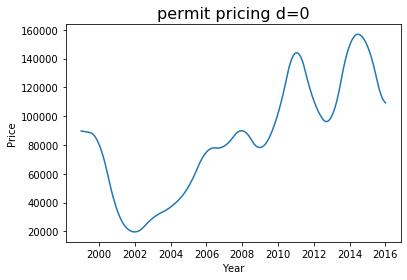

In [22]:

# d = 0
plt.plot(df['target']);
plt.title(label='permit pricing d=0', fontsize = 16)
plt.xlabel("Year")
plt.ylabel("Price");

In [23]:
interpret_dftest(df['target'])

Test Statistic   -0.811144
p-value           0.815827
dtype: float64

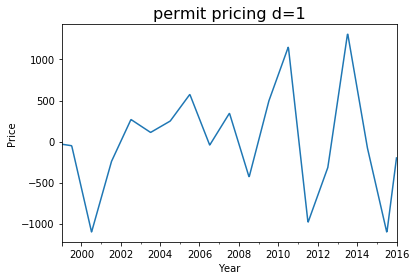

In [24]:
df['target'].diff().plot()
plt.title(label='permit pricing d=1', fontsize = 16)
plt.xlabel("Year")
plt.ylabel("Price");

In [25]:
interpret_dftest(df['target'].diff().dropna())

Test Statistic   -4.940128
p-value           0.000029
dtype: float64

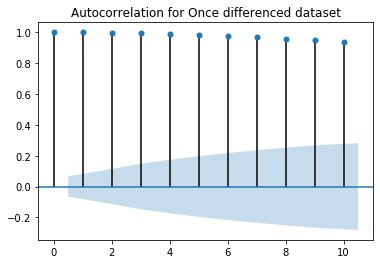

In [26]:
plot_acf(df['target'].diff().dropna(), lags = 10)
plt.title("Autocorrelation for Once differenced dataset");

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


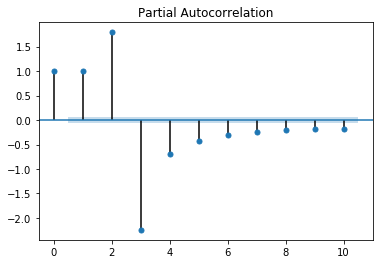

In [27]:

plot_pacf(df['target'].diff().dropna(), lags = 10);

In [28]:
order = (3, 1, 0)


# instantiate
arimax = ARIMA(
    y_train, 
    exog = Z_train,
    order = order, 
    freq = "W", # freq helps set the index column of predictions
    # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
arimax = arimax.fit()

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [29]:
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.target   No. Observations:                  665
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1539.068
Method:                       css-mle   S.D. of innovations        2334641.893
Date:                Mon, 01 Jun 2020   AIC                           3132.137
Time:                        19:04:56   BIC                           3253.631
Sample:                    01-10-1999   HQIC                          3179.212
                         - 10-02-2011                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             46.3182    550.759      0.084      0.933   -1033.149    1125.786
x1                -0.2612      0.644     -0.406      0.685      -1.523       1.000
x2                -0.2401      0.771     -0.312      0.755      -1.750       1.270
x3                -0.4751      1.165     -0.408      0.683      -2.758       1.808
x4                 0.8098      1.070      0.757      0.449      -1.287       2.907
x5                -0.5046      0.775     -0.651      0.515      -2.024       1.014
x6                -0.6814      1.292     -0.527      0.598      -3.214       1.851
x7                -0.3319      1.572     -0.211      0.833      -3.413       2.749
x8                -1.5865      1.491     -1.064      0.287      -4.509       1.336
x9                 0.2757      1.094      0.252      0.801      -1.868       2.420
x10                0.1572      1.585      0.099      0.921      -2.949       3.263
x11               -0.7129      1.728     -0.413      0.680      -4.100       2.674
x12               -0.6540      1.757     -0.372      0.710      -4.097       2.789
x13                0.2540      0.504      0.503      0.615      -0.735       1.243
x14                0.1331      0.743      0.179      0.858      -1.323       1.589
x15               -0.0454      0.057     -0.793      0.428      -0.158       0.067
x16               -0.0064      0.102     -0.062      0.950      -0.207       0.194
x17               -0.1803      0.135     -1.339      0.181      -0.444       0.084
x18                0.0223      0.625      0.036      0.972      -1.203       1.247
x19                0.4252      0.382      1.114      0.265      -0.323       1.174
x20               -0.2358      0.364     -0.648      0.517      -0.949       0.478
x21               -0.2673      0.147     -1.824      0.068      -0.555       0.020
x22                0.1782      0.321      0.555      0.579      -0.451       0.807
ar.L1.D.target     2.4671   4.43e-05   5.57e+04      0.000       2.467       2.467
ar.L2.D.target    -1.9550   3.67e-05  -5.32e+04      0.000      -1.955      -1.955
ar.L3.D.target     0.4879   4.04e-06   1.21e+05      0.000       0.488       0.488
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           +0.0000j            1.0000            0.0000
AR.2            1.0443           +0.0000j            1.0443            0.0000
AR.3            1.9627           +0.0000j            1.9627            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
arimax_train_preds = arimax.predict(start = 4, end = -1, exog = Z_train, typ = "levels")

In [31]:
arimax_test_preds  = arimax.predict(start = len(y_train), 
                                           end = len(y_train) + len(y_test) - 1, 
                                           exog = Z_test,
                                           typ = "levels",
                                           dynamic = False)

In [32]:
print(f'ARIMAX train RMSE is {rmse(y_train[arimax_train_preds.index],arimax_train_preds)}')
print(f'ARIMAX test RMSE is {rmse(y_test[arimax_test_preds.index],arimax_test_preds)}')

ARIMAX train RMSE is 2.405846112347952
ARIMAX test RMSE is 86773.2544383765


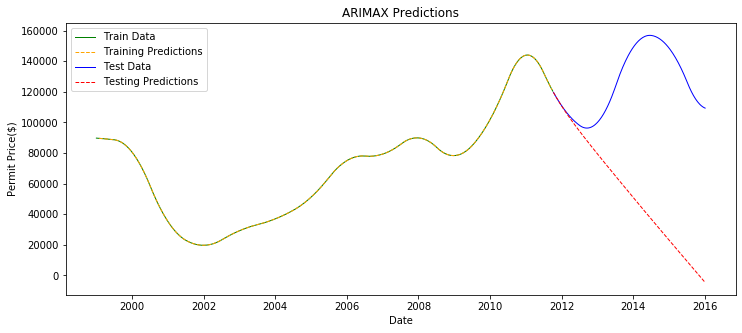

In [33]:
plt.figure(figsize=(12,5))
plt.title("ARIMAX Predictions")

# train data
plt.plot(y_train.index, y_train, lw=1, color='green', ls='solid',label='Train Data')

# train prediction
plt.plot(arimax_train_preds.index, arimax_train_preds, lw=1, color='orange', ls='dashed',label='Training Predictions')

# test data
plt.plot(y_test.index, y_test, lw=1, color='blue', ls='solid',label='Test Data')

# test predictions
plt.plot(arimax_test_preds.index, arimax_test_preds, lw=1, color='red', ls='dashed',label='Testing Predictions')

#  data
plt.xlabel("Date")
plt.ylabel("Permit Price($)")

plt.legend(loc = "upper left");


In [34]:
decomposed_result = seasonal_decompose(df['target'], model = "additive", period = 52)

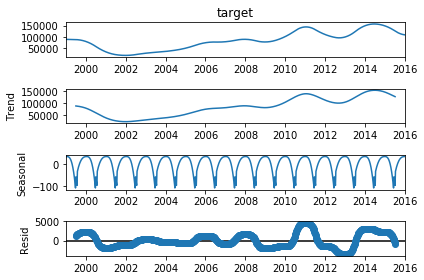

In [35]:

# plot decomposition
decomposed_result.plot();

In [36]:
df['target'].describe()

count       888.000000
mean      84108.673393
std       39323.202037
min       19693.749745
25%       49562.395410
50%       84013.614026
75%      112197.270234
max      156837.825898
Name: target, dtype: float64

In [37]:
order = (3, 1, 0)
seasonal_order = (3, 1, 0, 52)

# instantiate
sarimax = SARIMAX(
    y_train, 
    Z_train,
    order = order, 
    seasonal_order = seasonal_order, 
    freq = "W", # freq helps set the index column of predictions
    enforce_stationarity = False
    # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
sarimax = sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# fit, in case of convergence warning
# fitted_tour_sarima = tour_sarima.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [43]:
sarimax_train_preds = sarimax.predict(start = 1, end = -1, exog = Z_train, typ = "levels")

In [44]:
sarimax_test_preds  = sarimax.predict(start = len(y_train), 
                                           end = len(y_train) + len(y_test) - 1, 
                                           exog = Z_test,
                                           typ = "levels",
                                           dynamic = False)

In [45]:
print(f'SARIMAX train RMSE is {rmse(y_train[sarimax_train_preds.index],sarimax_train_preds)}')
print(f'SARIMAX test RMSE is {rmse(y_test[sarimax_test_preds.index],sarimax_test_preds)}')

SARIMAX train RMSE is 1220.372623989735
SARIMAX test RMSE is 23331.97318472928


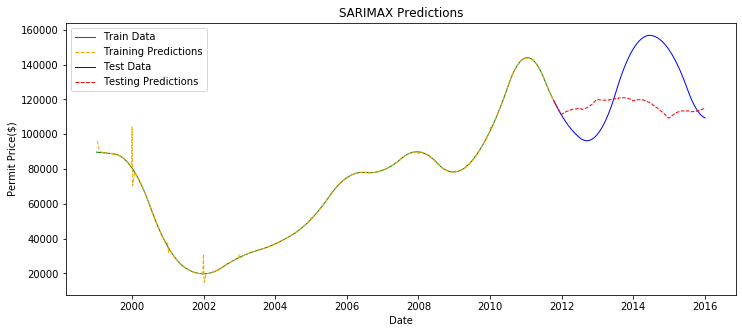

In [263]:
plt.figure(figsize=(12,5))
plt.title("SARIMAX Predictions")

# train data
plt.plot(y_train.index, y_train, lw=1, color='green', ls='solid',label='Train Data')

# train prediction
plt.plot(sarimax_train_preds.index, sarimax_train_preds, lw=1, color='orange', ls='dashed',label='Training Predictions')

# test data
plt.plot(y_test.index, y_test, lw=1, color='blue', ls='solid',label='Test Data')

# test predictions
plt.plot(sarimax_test_preds.index, sarimax_test_preds, lw=1, color='red', ls='dashed',label='Testing Predictions')

#  data
plt.xlabel("Date")
plt.ylabel("Permit Price($)")

plt.legend(loc = "upper left");



In [145]:
def get_diff(column, thresh = .05):
    '''Returns differencing results of amount of differencing required to make column stationary'''
    col_copy = column.copy() # make copy to changes are not affecting original column object
    d = 0 # start with d = 0
    adf_result = interpret_dftest(col_copy) # conduct ADF test
    while (adf_result["p-value"] > thresh): # if above p-value threshold, continue differencing until stationary
        d += 1
        col_copy = col_copy.diff().dropna()
        adf_result = interpret_dftest(col_copy)
    adf_result["d"] = d
    return adf_result

In [292]:
Z_train = (pd.DataFrame(Z_train, columns = [f"PC{i + 1}" for i in range(Z_train.shape[1])],index = X_train.index))

In [293]:
Z_test = (pd.DataFrame(Z_test, columns = [f"PC{i + 1}" for i in range(Z_test.shape[1])],index = X_test.index))

In [294]:

# For each column in dataframe, print result from get_diff
for col in Z_train.columns:
    adf_result = get_diff(Z_train[col])
    print(f"{col} is stationary with d={adf_result['d']} at p-value = {round(adf_result['p-value'], 3)}")
          

PC1 is stationary with d=1.0 at p-value = 0.0
PC2 is stationary with d=2.0 at p-value = 0.0
PC3 is stationary with d=2.0 at p-value = 0.0
PC4 is stationary with d=0.0 at p-value = 0.036
PC5 is stationary with d=0.0 at p-value = 0.012
PC6 is stationary with d=0.0 at p-value = 0.002
PC7 is stationary with d=0.0 at p-value = 0.001
PC8 is stationary with d=0.0 at p-value = 0.0
PC9 is stationary with d=0.0 at p-value = 0.0
PC10 is stationary with d=0.0 at p-value = 0.0
PC11 is stationary with d=0.0 at p-value = 0.0
PC12 is stationary with d=0.0 at p-value = 0.0
PC13 is stationary with d=0.0 at p-value = 0.0
PC14 is stationary with d=1.0 at p-value = 0.0
PC15 is stationary with d=0.0 at p-value = 0.0
PC16 is stationary with d=0.0 at p-value = 0.0
PC17 is stationary with d=0.0 at p-value = 0.0
PC18 is stationary with d=0.0 at p-value = 0.0
PC19 is stationary with d=0.0 at p-value = 0.0
PC20 is stationary with d=0.0 at p-value = 0.0
PC21 is stationary with d=0.0 at p-value = 0.0
PC22 is statio

In [295]:
Z_train['PC1'] = Z_train['PC1'].diff()
Z_train['PC2'] = Z_train['PC1'].diff().diff()
Z_train['PC3'] = Z_train['PC1'].diff().diff()
Z_train['PC14'] = Z_train['PC14'].diff()


In [296]:
for col in Z_test.columns:
    adf_result = get_diff(Z_test[col])
    print(f"{col} is stationary with d={adf_result['d']} at p-value = {round(adf_result['p-value'], 3)}")

PC1 is stationary with d=0.0 at p-value = 0.029
PC2 is stationary with d=2.0 at p-value = 0.0
PC3 is stationary with d=2.0 at p-value = 0.0
PC4 is stationary with d=2.0 at p-value = 0.0
PC5 is stationary with d=2.0 at p-value = 0.0
PC6 is stationary with d=1.0 at p-value = 0.023
PC7 is stationary with d=1.0 at p-value = 0.004
PC8 is stationary with d=1.0 at p-value = 0.037
PC9 is stationary with d=2.0 at p-value = 0.0
PC10 is stationary with d=1.0 at p-value = 0.024
PC11 is stationary with d=2.0 at p-value = 0.0
PC12 is stationary with d=0.0 at p-value = 0.009
PC13 is stationary with d=0.0 at p-value = 0.0
PC14 is stationary with d=1.0 at p-value = 0.0
PC15 is stationary with d=0.0 at p-value = 0.0
PC16 is stationary with d=0.0 at p-value = 0.0
PC17 is stationary with d=0.0 at p-value = 0.0
PC18 is stationary with d=1.0 at p-value = 0.0
PC19 is stationary with d=0.0 at p-value = 0.0
PC20 is stationary with d=1.0 at p-value = 0.0
PC21 is stationary with d=1.0 at p-value = 0.0
PC22 is st

In [297]:
Z_test['PC2'] = Z_test['PC2'].diff().diff()
Z_test['PC3'] = Z_test['PC3'].diff().diff()
Z_test['PC4'] = Z_test['PC4'].diff().diff()
Z_test['PC5'] = Z_test['PC5'].diff().diff()
Z_test['PC6'] = Z_test['PC6'].diff()
Z_test['PC7'] = Z_test['PC7'].diff()
Z_test['PC8'] = Z_test['PC8'].diff()
Z_test['PC9'] = Z_test['PC9'].diff().diff()
Z_test['PC10'] = Z_test['PC10'].diff()
Z_test['PC11'] = Z_test['PC11'].diff().diff()
Z_test['PC14'] = Z_test['PC14'].diff()
Z_test['PC18'] = Z_test['PC18'].diff()
Z_test['PC20'] = Z_test['PC20'].diff()
Z_test['PC21'] = Z_test['PC21'].diff()
Z_test['PC22'] = Z_test['PC22'].diff()



In [298]:
Z_test.dropna(inplace=True)
Z_train.dropna(inplace=True)

In [337]:
v_test = y_test[Z_test.index]

In [338]:
#_train[Z_train.index]
v_train = y_train[Z_train.index]
train = pd.merge(left = v_train,right = Z_train,left_index=True,right_index=True)
test = pd.merge(left = v_test,right = Z_test,left_index=True,right_index=True)

In [339]:
test

,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
year,,,,,,,,,,,,,,,,,,,,,
2011-10-23,117997.144320,43.420362,-0.000007,-0.000001,5.169842e-07,-0.000007,-0.004440,-0.058365,-0.176954,9.804037e-07,...,3.510100,0.578585,-0.830388,-1.424895,-0.089485,0.003136,0.806822,0.029312,0.067114,0.066082
2011-10-30,117220.203726,43.498655,-0.000007,-0.000001,5.169842e-07,-0.000007,-0.004437,-0.058361,-0.176955,9.804037e-07,...,3.719329,0.578584,-0.848722,-1.440025,-0.093059,0.003132,0.840420,0.029311,0.067116,0.066076
2011-11-06,116455.988298,43.534628,-0.037885,0.004823,-2.080971e-02,-0.025836,-0.008449,-0.052449,-0.167262,5.419396e-03,...,3.922762,0.607845,-0.870036,-1.472183,-0.091581,0.044564,0.836130,0.042272,0.083064,0.046759
2011-11-13,115704.498037,43.655266,0.075750,-0.009650,4.162096e-02,0.051652,-0.000415,-0.064263,-0.186649,-1.083585e-02,...,4.137785,0.549321,-0.885390,-1.470282,-0.100202,-0.038313,0.907624,0.016346,0.051174,0.085374
2011-11-20,114965.732942,43.733585,-0.037885,0.004823,-2.080971e-02,-0.025836,-0.004427,-0.058350,-0.176957,5.419396e-03,...,4.347012,0.578581,-0.903724,-1.485410,-0.103771,0.003119,0.941230,0.029307,0.067122,0.066057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-06,110309.538224,66.476298,-0.082084,0.008103,-3.844172e-02,-0.058208,0.017081,0.013969,-0.051188,1.107181e-02,...,6.536715,0.109518,-0.904142,-2.138513,-0.086338,0.038401,2.116285,0.040764,0.024823,-0.017283
2015-12-13,110003.744541,66.537421,0.164513,-0.016188,7.689515e-02,0.116709,0.022181,-0.019803,-0.084435,-2.217387e-02,...,6.576446,0.004791,-0.901985,-2.106090,-0.092088,-0.102320,2.181121,-0.003675,-0.042402,0.070258
2015-12-20,109733.737631,66.529527,-0.082084,0.008103,-3.844172e-02,-0.058208,0.019568,-0.002997,-0.067796,1.107181e-02,...,6.604535,0.057170,-0.905351,-2.103944,-0.086058,-0.031888,2.179626,0.018564,-0.008850,0.026597


In [353]:
Z = pd.concat([train,test])
Z.index = pd.DatetimeIndex(Z.index).to_period('W')

In [354]:
var = VAR(Z,freq = "W")

In [355]:
fitted_var = var.fit(maxlags=20, ic = "aic")

In [356]:
fitted_var.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Jun, 2020
Time:                     13:01:06
--------------------------------------------------------------------
No. of Equations:         23.0000    BIC:                   -56.2188
Nobs:                     879.000    HQIC:                  -63.4004
Log likelihood:           3271.39    FPE:                3.48378e-30
AIC:                     -67.8477    Det(Omega_mle):     3.44724e-31
--------------------------------------------------------------------
Results for equation target
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             5.516849         5.993989            0.920           0.357
L1.target         3.195817         0.590968            5.408           0.000
L1.PC1           76.487621        24.625442            3.106           0.00

In [358]:


starting_index = round(len(Z) * .8) # starting split after 80% of observations are in "training" set

train = Z.iloc[:starting_index,:]

test  = Z.iloc[starting_index:,:]

In [359]:

# get predictions and confidence intervals for "test" set
test_preds, lower_conf_ints, upper_conf_ints = fitted_var.forecast_interval(train.values, len(test))

In [360]:

var_preds = test_preds[:,0]
var_true = test.iloc[:,0]

In [361]:
print(f'VAR RMSE is {rmse(var_true,var_preds)}')


VAR RMSE is 24424.33347985011


In [403]:
X = df.drop(columns = 'target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    shuffle = False)
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)


pca_99 = PCA(.99, random_state = 42)

Z_train = pca_99.fit_transform(X_train_ss)
Z_test = pca_99.transform(X_test_ss)

array([[-0.28001275, -0.27522102, -0.24601095, ..., -0.88142576,
        -0.36918418,  0.36700842],
       [-0.28001275, -0.27522102, -0.24601095, ..., -0.88357404,
        -0.37236717,  0.39356601],
       [-0.28001275, -0.27522102, -0.24601095, ..., -0.88572231,
        -0.37555016,  0.42012361],
       ...,
       [-0.28001275, -0.27522102, -0.24601095, ...,  1.53804289,
         1.63743869,  0.30191878],
       [-0.28001275, -0.27522102, -0.24601095, ...,  1.52312347,
         1.64014558,  0.30191878],
       [-0.28001275, -0.27522102, -0.24601095, ...,  1.50820405,
         1.64285248,  0.30191878]])

In [409]:
train_sequences = TimeseriesGenerator(X_train_ss, y_train, length=3, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_ss, y_test, length=3, batch_size=64)

In [432]:
model = Sequential()
model.add(GRU(8, input_shape=(22,8), return_sequences=True))
model.add(GRU(8))

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='linear'))

In [433]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [434]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 (None, 22, 8)             432       
_________________________________________________________________
gru_35 (GRU)                 (None, 8)                 432       
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 5         
Total params: 905
Trainable params: 905
Non-trainable params: 0
_________________________________________________________________
